In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange

### Components: PD, MZ Intensity Modulator, Electronic combiner, Optical Attenuator, Readout, CW Laser

In [2]:
class PD(pt.Component):
    """
    A photodector which acts instantaneously on the input optical power,
    converting it to current according to the input wavelength-independendt responsivity.
    Note: At R=1, this is the equivalent component of the built-in detector term.
    An optional Resistance can be added to output a voltage instead, to model a simple TIA operating at DC.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        R = 1, #Responsivity
        Z = 1, #TIA Impedence (Resistance)
        name = None,  
        ):
        
        super(PD,self).__init__(name=name)    
        self.R = float(R)
        self.Z = float(Z)
        
    def action(self, t, x_in, x_out):
        
        a_in, _ = x_in

        x_out[0] = a_in  #Nothing happens to input node
        
        
        x_out[1,0] = self.R*self.Z*(a_in[0]**2+a_in[1]**2)  #PD Equation
        
        x_out[1,1] = 0  #lose the phase information
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [3]:
class mzm(pt.Component):
    """
    This is a 3 port implementation of symmetric mzm-based (equal arm-lengths) Intensity modulator. 
    An input voltage adds a phase to the phase induced by one of the arms.
    Note: This implementation assumes it will be connected to a direct optical source.

    Terms: 
  Optical  0 ----- 2  Optical
               |
               |
               1 
           Electrical
    
    """    
    num_ports = 3
    
    def __init__(
        self,
        trainable = False,
        vpi = 3.0, #Voltage to acquire Pi phase shift
        bias=0.0, #Input bias phase 
        neff = 2.34, #effective index
        ng = 3.40, #group index
        wl0 = 1.55e-6, #wavelength for defined neff
        length = 1.5e-9, #waveguide length (m)
        loss = 0, #The loss would be both Y-jun loss + both waveguide losses
        name = None,  
        ):
        
        super(mzm,self).__init__(name=name)    
        self.vpi = float(vpi)
        self.neff = float(neff)
        self.ng = float(ng)
        self.length = float(length)
        self.loss = float(loss)
        self.wl0 = float(wl0)
        if trainable:
            self.bias = BoundedParameter(
            data=torch.tensor(bias, device=self.device),
            bounds=(0.0, 2*np.pi),
            requires_grad=True,
            )
        else:
            self.bias = pt.Buffer(
            data=torch.tensor(bias, device=self.device), requires_grad=False
            )
    #def set_delays(self,delays):
        #delays[:] = self.ng * self.length/self.env.c
        
    def action(self, t, x_in, x_out):
        
        a_in, v_in, _ = x_in     #Port0: input optical amplitude, Port1: input Voltage, Port2: O/p node (no need to store)
        
        v = v_in[0]  #The 'real' part of voltage signal 
        #print(a_in)  #for debugging
        
        x_out[0] = a_in  #Nothing happens to optical input node
        
        x_out[1] = v_in #Nothing happens to electrical input port
        
        wls = torch.tensor(self.env.wl, dtype=torch.float64, device=self.device)

        # neff depends on the wavelength:
        neff = self.neff - (wls - self.wl0) * (self.ng - self.neff) / self.wl0
        
        phase = (2 * np.pi * neff * self.length / wls) # Phase due to waveguide propagation 
        
        #Ei = torch.sqrt(a_in[0]**2 + a_in[1]**2) #Input amplitude
        Ei = a_in[0]                  # For Real Sources Only!
        
        mzm_eq_re = 0.5 * Ei * (torch.cos(phase) + torch.cos(phase + np.pi * (v / self.vpi)+ self.bias))  #Real
        mzm_eq_im = 0.5 * Ei * (torch.sin(phase) + torch.sin(phase + np.pi * (v / self.vpi)+ self.bias)) #Imaginary
        
        x_out[2,0] = mzm_eq_re # + 0.001 For extinction ratio
        x_out[2,1] = mzm_eq_im 
        
        #print(x_out[2])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1  #Actions must be defined for all ports in active devices
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        S[0,:,2,2] = 1.0
        return S

In [4]:
class attenuator(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(attenuator, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = pt.Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [5]:
class combiner(pt.Component):
    """
    The electronic combiner is a 3 port component that linearly combines 2 signals then multiplies both by a gain factor.
    The gain is trainable. Note: The circuit is not symmetric.
    Note: The signals entering the i/p ports are assumed to have no phase difference.
    
    Terms: 
  Electrical i/p  0 ----- 2  Electrical o/p
                      |
                      |
                      1 
                 Electrical i/p
            
    """      
    num_ports = 3
    
    def __init__(
    self,
    trainable = True,
    gain = 1.0,
    name=None,
    ): 
        super(combiner, self).__init__(name=name)
        if trainable:
            self.gain = BoundedParameter(
            data=torch.tensor(gain, device=self.device),
            bounds=(1.0, 100.0),
            requires_grad=True,
            )
        else:
            self.gain = pt.Buffer(
            data=torch.tensor(gain, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,2,0] = S[0,:,2,1] = (self.gain ** 0.5) 
        return S

In [6]:
class readout(pt.Component):
    """
    This component contains the readout weights, which is trainable. Depending on the number of nodes N in the reservoir,
    the output, which is an weighted sum of every N timesteps, is sampled once every N timesteps (i.e. every discrete 
    timestep of the system). This output is the expected value predicted by the reservoir.
     
    Note there is no value for node spacing. This was chosen for the simple solution of choosing sim timestep to be theta.


    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        N = 10,
        weights = torch.randn(10, dtype=torch.float32, device=torch.device('cpu')),
        trainable = False,
        name = None,  
        ):
                
        super(readout,self).__init__(name=name) 
        self.N = float(N)                   #Number of virtual nodes
        self.index = int()                  #To access the weight matrix
        self.y_hat_stored = float()         #Linear combination of previous reservoir state
        self.y_hat = float()                #Linear combination of current reservoir state (Predicted Value)
        
        if trainable:
            self.weights = BoundedParameter(
            data=weights.clone().detach(),
            bounds=(-100, 100),
            requires_grad=True,
            )
        else:
            self.weights = pt.Buffer(
            data=weights.clone().detach(), requires_grad=False, 
            )        
        
        
    def action(self, t, x_in, x_out):
            
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        #Initialization
        power = (a_in[0]**2 + a_in[1]**2)
        if t == 0:
            self.index = -1
            self.y_hat_stored=0
            self.y_hat = 0

        #Updates
        self.index = self.index + 1 
        self.y_hat = self.y_hat + torch.sqrt(power*self.weights[self.index])  #Weighted linear Combination of states of virtual nodes
        
        if self.index == self.N - 1:
            self.y_hat_stored = self.y_hat
            self.y_hat = 0
            self.index = -1
            #print(self.y_hat_stored)

        x_out[1] = self.y_hat_stored

    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S
    
    """
    For Testing:
    
    #print(self.counter)        
    #print(self.y_hat_stored)
    #print(self.index)
    
    """
    

In [7]:
class cw_laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 
    0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(cw_laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [8]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [9]:
'''----- Optoelectronic Reservoir with Electrical Input -----'''

class oe_reservoir(pt.Network):
    def __init__(self,gain=3, las_pow = 1, attenuation=0.3, wg_delay=0.1e-9, wg_ng=2.6734, nodes=10, mask_vector=torch.ones(10, dtype=torch.float64), weights = 0.01*torch.randn(10, dtype=torch.float64),bias=2):
        super(oe_reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.pd = PD(Z=1)
        self.mask_ = mask(m_length=nodes, mask_vector = mask_vector)
        self.comb = combiner(gain=gain, trainable = False)
        self.att = attenuator(attenuation=attenuation, trainable = False) 
        self.laser = cw_laser(Power=las_pow, delay=0) 
        self.laser2 = cw_laser(Power=0.0,delay=0)
        self.laser3 = cw_laser(Power=1,delay=0)
        self.term = pt.Term()
        self.term2 = pt.Term()
        self.mmi = pt.Mmi(trainable=False)
        self.wg = pt.Waveguide(ng=wg_ng,length=299792458*wg_delay/wg_ng, trainable = False)
        self.mzm = mzm(bias=bias, trainable=False)
        self.link("term:0", "0:laser:1", "0:mzm:2", "0:mmi:1", "0:att:1", "0:wg:1", "0:pd:1", "0:comb:2", "1:mzm")
        self.link("mmi:2", "0:det")
        self.link("src:0", "0:mask_:1", "1:comb")

In [10]:
'''----- Optoelectronic Reservoir with Optical Input -----'''

class op_reservoir(pt.Network):
    def __init__(self,gain=3, las_pow = 1, attenuation=0.3, wg_delay=0.1e-9, mask_vector=torch.ones(10), wg_ng=2.6734, nodes=10, weights = 0.01*torch.randn(10, dtype=torch.float64),bias=2):
        super(op_reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.pd = PD(Z=1)
        self.mask_ = mask(m_length=nodes, mask_vector = mask_vector)
        self.comb = combiner(gain=gain, trainable = False) #np.random.uniform(low=1.0,high=30.0)
        self.att = attenuator(attenuation=attenuation, trainable = False) #np.random.uniform(low=0.0,high=1.0)
        self.laser = cw_laser(Power=las_pow, delay=0) #0.15e-9
        self.laser2 = cw_laser(Power=0.0,delay=0)
        self.laser3 = cw_laser(Power=1,delay=0)
        self.term = pt.Term()
        self.term2 = pt.Term()
        self.mmi = pt.Mmi(trainable=False)
        self.wg = pt.Waveguide(ng=wg_ng,length=299792458*wg_delay/wg_ng, trainable = False)
        self.mzm = mzm(bias=bias, trainable=False)
        self.link("src:0", "0:mask_:1", "0:mzm:2", "0:mmi:1", "0:att:1", "0:wg:1", "0:pd:1", "0:comb:2", "1:mzm")
        self.link("mmi:2", "0:det")
        self.link("term:0", "1:comb")

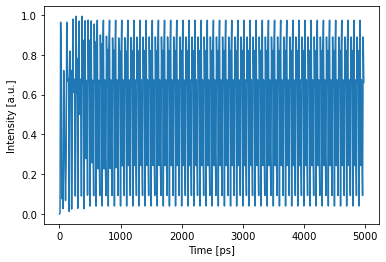

In [11]:
torch.manual_seed(3)

#Reservoir Parameters
wg_delay = 0.1e-9  #Delay line, it automatically controls the waveguide length (Along with group index below)
ng = 2.6734  #To use the parameters of LNOI
gain = 5 #feedback gain
att = 0.4  #optical attenuator
las_pow = 2 #Laser Power
bias=3
#Simulation parameters
N = 10                                             #no. of 'virtual' nodes in the reservoir
sim_time = 5e-9                                   #Simulation time [s]
dt = wg_delay/N                                    #timestep [s] - also the virtual node distance
samples = np.int(np.ceil(1*sim_time/dt))             #Number of samples from the reservoir
weights = 0.01*torch.randn(N, dtype=torch.float32) #Initialized Weights
wl = 1.55e-6                                       #Center Wavelength [m]
mask_ = torch.randn(N)
Reservoir = oe_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, nodes=N, mask_vector=mask_, weights=weights, bias=bias)
#Reservoir_el = simple_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, nodes=N, weights=weights, bias=bias)

time_env = pt.Environment(dt=dt, t1=sim_time, wl=wl)

x = (1-0)*torch.rand(1000,names=["t"])
#for p in Reservoir.parameters():
    #print(p)
    
with time_env:
    detected = Reservoir(source=1)  ###Write the desired input Power value here
    Reservoir.plot(detected)
    plt.show()

# We now proceed to train the circuit for Narma10 Task

In [12]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [13]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y

TARGET = narma10_jaeger 

# ----- TESTING -----

#u = (0.5-0)*torch.rand(100)
#print(narma10_jaeger(u))
#print(narma10(u))
#diff = narma10_jaeger(u)-narma10(u)
#print(diff)

In [83]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 100000                               #[1/s] bitrate
Rs = 50*Rb                                #[1/s] samplerate  e9 originally
fc = 2e6                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 1.45                               #[1] effective index
ng = 1.522                                #[1] group index
N = 2000                                  #[1] number of bits per bit stream
B = 1                                     #[1]number of bit streams in training batch
sim_time = N/Rb                           #Simulation time [s]
wl = 1.55e-6                              #Center Wavelength [m]
Str, Sva, Ste = (10, 2, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance the bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
wg_delay = 10.6e-6                   #[s] Delay tao(Along with group index below)
ng = 1.522                           #[1] Group index
gain = 15                            #[1] Feedback gain
att = 0.1                            #[1] Optical attenuator
las_pow = 1                          #[1] Laser Power
bias=0                               #[1] MZM Bias
Nodes = np.int(Rs/Rb)                #[1] Number of virtual nodes in the reservoir
mask_vector = torch.rand(Nodes)      #Input mask
weights_ = 0.01*torch.randn(Nodes, dtype=torch.float32, device=device)    #Initialized Weights

# ----- TESTING -----
#print(Nodes)
#print(sim_time)
#print(wg_delay*(c/ng))
#print(Lr)
#print(1/Rb)

In [84]:
'''----- BITS GENERATION -----'''

bits = Narma10Generator(seed=23)(100,2)
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)
stream = streamgen(bits)
target = streamgen(TARGET(bits))**2
#print(target.shape)
#t = np.arange(stream.shape[0])*(1/Rs)
#plt.plot(1e9*t, stream.data.cpu().numpy())
#plt.plot(1e9*t, target.data.cpu().numpy())
#plt.legend(['Input', 'Target'])
#plt.xlabel("t [ns]")
#plt.show()
#streamgen(TARGET(bits))

In [85]:
'''TRAINING CIRCUITS'''
Reservoir2 = oe_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, mask_vector=mask_vector, nodes=Nodes, weights=weights_, bias=bias)
Reservoir3 = op_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, mask_vector=mask_vector, nodes=Nodes, weights=weights_, bias=bias)

In [86]:
'''----- BITSTREAMS -----'''

# train streams
trbits = Narma10Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))
trtarget_np = trtarget.numpy()

# validation streams
vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))


# test streams
tebits = Narma10Generator(seed=Ste)(N*B, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits)) 

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

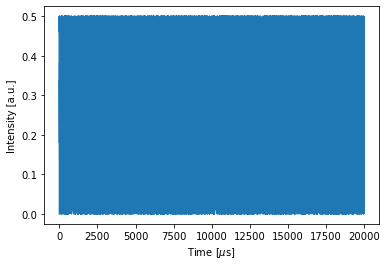

In [87]:
'''----- Run Electrical Input Reservoir -----'''
with pt.Environment(t=t):
    detected = Reservoir2(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    Reservoir2.plot(detected)
    plt.show()
    
detected_np = detected.numpy()

(2000, 50)
[[-1.1572919e-02 -5.5402881e-01  1.1239492e+00  4.9245968e-02
   1.0505805e+00 -1.5613097e-01  7.4916410e-01 -1.2426913e-01
  -2.9835522e-02 -3.7536767e-01  1.9250527e-01 -9.7516274e-01
   2.6501858e-01 -5.4743201e-01  5.1725721e-01  1.1069843e-01
   7.1725571e-01 -3.0366629e-01  7.0425677e-01 -2.0826873e-01
  -3.5455605e-01 -7.0945418e-01  4.9112102e-01 -6.2126398e-01
   2.7670828e-01 -8.7084934e-02  5.5845523e-01 -2.2101142e-01
   4.6519446e-01  3.9514962e-01  7.6177716e-03 -1.2302525e+00
   2.6281506e-02 -3.9838642e-01 -4.0170372e-02 -9.9354982e-04
   1.3828204e+00  2.5082526e-01  5.7285762e-01 -2.3946846e-01
   3.6167544e-01  3.2811111e-01 -1.9419932e-01 -1.9770007e-01
   5.7254028e-01  3.8059473e-01 -6.7698002e-01 -9.0080023e-02
   1.2738591e-01  2.5639021e-01]]
mse is: [0.00430097], nmse is: 0.42272101607778967


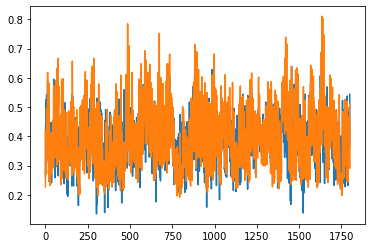

In [88]:
Bits = N

regr = linear_model.LinearRegression()
w = np.ones(Nodes)

def mse(target,predicted,N):
    mse = 0
    for i in range(N):
        mse = mse+(target[N*i] - predicted[N*i])**2
    mse = mse/50
    return mse
#print(trtarget.shape)
#new_target = new_target.reshape()
detected_np = detected_np.reshape(Bits,Nodes)
trbitsx = Narma10Generator(seed=Str)(Bits, 1) # N bits per train stream, B train streams per batch.
target_now = narma10_jaeger(trbitsx).numpy().reshape(Bits,1)

print(detected_np.shape)

detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
nmse = 1 - regr.score(detected_np_cut,target_now_cut)

print(regr.coef_)

plt.plot(y)
plt.plot(target_now_cut)

def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

mse = mse_new(target_now_cut,y,Bits)

print(f'mse is: {mse}, nmse is: {nmse}')


In [ ]:
regr2 = linear_model.LinearRegression()
#print(type(detected))
w = np.ones(Nodes)
#sample_weights = np.tile(w,100)
#print(sample_weights.size)
#detected_sampled = readout(det=detected,weights=w)
#print(detected_sampled.size)
#print(trtarget.shape)
#new_target = new_target.reshape()
detected_op_np = detected_op_np.reshape(Bits,Nodes)
trbitsx2 = Narma10Generator(seed=Str)(Bits, 1) # N bits per train stream, B train streams per batch.
target_now2= narma10_jaeger(trbitsx).numpy().reshape(Bits,1)
#print(target_now.shape)
#print(w.shape)
#print(detected.shape)
#print(np.matmul(w,detected))
#nmse = mse(trtarget_np,detected_sampled,Nodes)/np.mean((trtarget_np-np.mean(trtarget_np))**2)
#print(len(new_target))
#detected_cut2 = detected2[:,10:]
#target_now_cut2 = target_now2[10:]
x2 = regr2.fit(detected_op_np,target_now2)
y2 = regr2.predict(detected_op_np)
nmse = 1 - regr2.score(detected_op_np,target_now2)
#print(regr.coef_.shape)

#print(regr2.coef_)

#regr.predict(trstream)
#print(nmse)
#print(mse(trtarget_np,detected_sampled,N))
#print(mse(trtarget_np,detected_sampled,N))
#plt.plot(trtarget_np)
plt.plot(y2)
plt.plot(target_now2)
print(y2.shape)
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

mse = mse_new(target_now2,y2,Bits)
#var = np.sum((target_now_cut-np.mean(target_now_cut))**2)/Bits
#nmse = mse / var
#print(var)
print(f'mse is: {mse}, nmse is: {nmse}')
#print(mse(trtarget_np,y,50)/np.mean((trtarget_np-np.mean(trtarget_np))**2))
#plt.show()

In [89]:
weights_2 = regr.coef_
intercept = regr.intercept_
#print(weights_2.T)
print(weights_2)
weights_2= weights_2.reshape(50,)
print(weights_2)
print(np.shape(weights_2))
#weights_2 = torch.sqrt(torch.from_numpy(weights_2))

[[-1.1572919e-02 -5.5402881e-01  1.1239492e+00  4.9245968e-02
   1.0505805e+00 -1.5613097e-01  7.4916410e-01 -1.2426913e-01
  -2.9835522e-02 -3.7536767e-01  1.9250527e-01 -9.7516274e-01
   2.6501858e-01 -5.4743201e-01  5.1725721e-01  1.1069843e-01
   7.1725571e-01 -3.0366629e-01  7.0425677e-01 -2.0826873e-01
  -3.5455605e-01 -7.0945418e-01  4.9112102e-01 -6.2126398e-01
   2.7670828e-01 -8.7084934e-02  5.5845523e-01 -2.2101142e-01
   4.6519446e-01  3.9514962e-01  7.6177716e-03 -1.2302525e+00
   2.6281506e-02 -3.9838642e-01 -4.0170372e-02 -9.9354982e-04
   1.3828204e+00  2.5082526e-01  5.7285762e-01 -2.3946846e-01
   3.6167544e-01  3.2811111e-01 -1.9419932e-01 -1.9770007e-01
   5.7254028e-01  3.8059473e-01 -6.7698002e-01 -9.0080023e-02
   1.2738591e-01  2.5639021e-01]]
[-1.1572919e-02 -5.5402881e-01  1.1239492e+00  4.9245968e-02
  1.0505805e+00 -1.5613097e-01  7.4916410e-01 -1.2426913e-01
 -2.9835522e-02 -3.7536767e-01  1.9250527e-01 -9.7516274e-01
  2.6501858e-01 -5.4743201e-01  5.17257

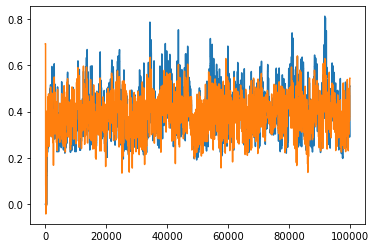

In [90]:
def readout(detected,weights,Bits, flag=True):
    weights_tile = np.tile(weights,Bits)
    detected_tile = detected.flatten()
    readout_now = detected_tile * weights_tile
    out=np.zeros(Bits)
    out_res = np.zeros_like(detected_tile)
    counter = 0
    step = 0
    
    #To print the linear summation of nodes (reservoir states x[n])
    if flag == True:
        for i in range(100):
            out[i] = np.sum(readout_now[step:step+weights.size]) + intercept
            step = step+50
        y = out
        
    #To print the readout as would appear sampled and held from the system
    else:
        for i in range(detected_tile.size):
            out_res[i*weights.size:(i*weights.size)+weights.size] = np.sum(readout_now[step:step+weights.size]) + intercept
            step = step + weights.size
        y = out_res
    return y


# ===== Predicted vs Expected =====
expected_readout = np.repeat(target_now,Nodes)
predicted_readout = readout(detected_np, weights_2,Bits, flag=False)                
plt.plot(expected_readout)
plt.plot(predicted_readout)
plt.show()

In [91]:
'''VALIDATION CIRCUITS'''
Reservoir2_va = oe_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, mask_vector=mask_vector, nodes=Nodes, weights=weights_, bias=bias)
Reservoir3_va = op_reservoir(gain=gain, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, mask_vector=mask_vector, nodes=Nodes, weights=weights_, bias=bias)

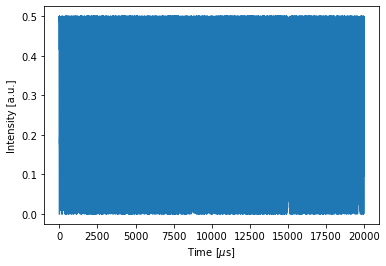

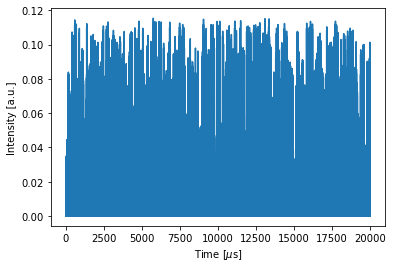

In [92]:
'''VALIDATION STREAMS'''

with pt.Environment(t=t):
    detected_va = Reservoir2_va(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    Reservoir2_va.plot(detected_va)
    plt.show()
    #print(type(detected))
    
detected_va_np = detected_va.numpy()
#print(detected)

with pt.Environment(t=t):
    detected_op_va = Reservoir3_va(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    Reservoir3_va.plot(detected_op_va)
    plt.show()
    
detected_op_va_np = detected_op_va.numpy()

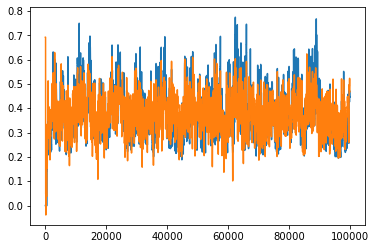

In [93]:
vabitsx = Narma10Generator(seed=Sva)(Bits, 1) # N bits per train stream, B train streams per batch.
target_va = narma10_jaeger(vabitsx).numpy().reshape(Bits,1)
expected_va_readout = np.repeat(target_va,Nodes)
predicted_va_readout = readout(detected_va_np, weights_2,Bits, flag=False)                
plt.plot(expected_va_readout)
plt.plot(predicted_va_readout)
plt.show()


In [95]:
'''------ TEST SCORING -----'''
detected_va_np = detected_va_np.reshape(Bits,Nodes)
mse_va = mean_squared_error(expected_va_readout, predicted_va_readout)
nmse_va = 1 - regr.score(detected_va_np,target_va)
print(f'mse is: {mse_va}, nmse is: {nmse_va}')

mse is: 0.005333170760422945, nmse is: 0.45157614055941986
